# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

## Исследовательский анализ данных

Импортируем библиотеки.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Посмотрим на размер выборки и импортируем таблицу с целевым признаком.

In [2]:
path = '/datasets/faces/'

data_path, dirs, files = next(os.walk(path + 'final_files'))
labels = pd.read_csv(path + 'labels.csv')

print('В директории %s файл.' % len(files))

В директории 7591 файл.


Взглянем на таблицу.

In [3]:
print(labels.info())
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Пропусков нет. Построим графики распределения возраста в выборке.

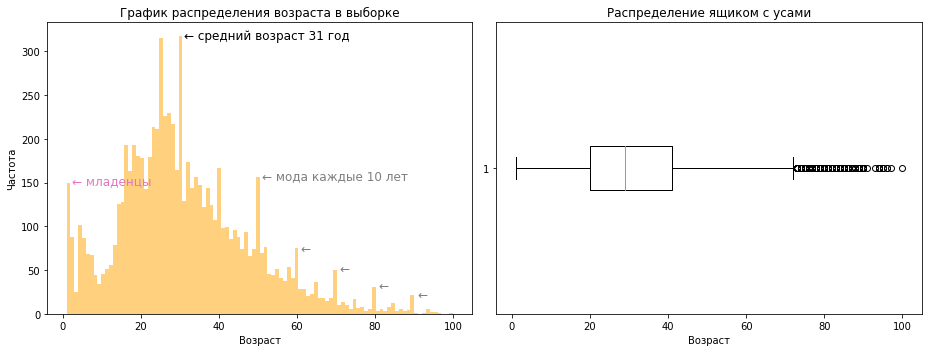

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(13, 5)

data = labels.real_age

ax1.hist(x=data, bins=100, color='orange', alpha=0.5)
ax1.set_title('График распределения возраста в выборке')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')

# текстовые подписи
ax1.text(x=2.5, y=148, s='← младенцы', fontsize='large', color='tab:pink')
ax1.text(x=data.mean(), y=314, s='← средний возраст 31 год', fontsize='large')
ax1.text(x=51, y=154, s='← мода каждые 10 лет', fontsize='large', color='tab:gray')
ax1.text(x=61, y=71, s='←', fontsize='large', color='tab:gray')
ax1.text(x=71, y=48, s='←', fontsize='large', color='tab:gray')
ax1.text(x=81, y=28, s='←', fontsize='large', color='tab:gray')
ax1.text(x=91, y=18, s='←', fontsize='large', color='tab:gray')

ax2.boxplot(data, vert=False)
ax2.set_title('Распределение ящиком с усами')
ax2.set_xlabel('Возраст')

plt.tight_layout()
plt.show()

Распределение перекошено вправо и содержит повторяющуюся аномалию: больше фотографий в возрасте кратном 10.

Настроим загрузчик.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=data_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузим 16 фотографий из набора и выведем их.

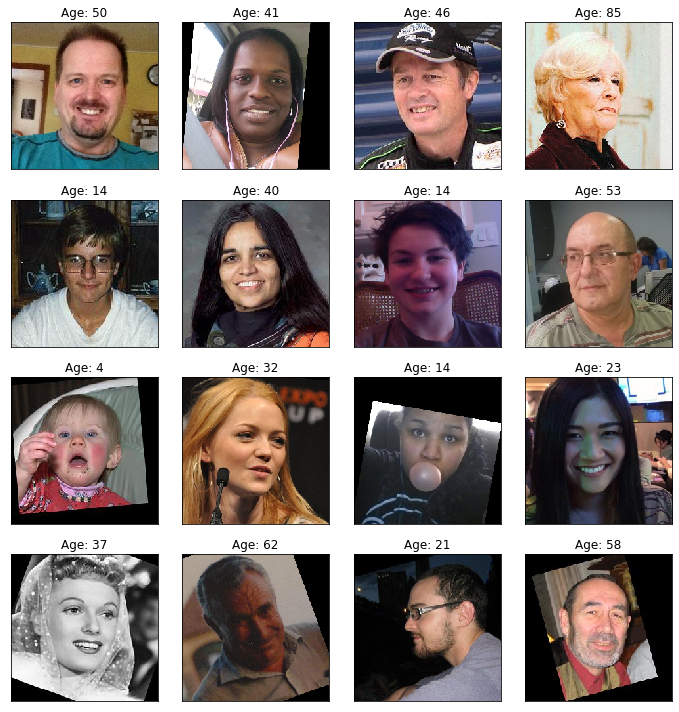

In [6]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси
    # прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: %s' % target[i])

### Вывод

* Целостность данных не нарушена: 7591 файл, столько же изображений и объектов в датафрейме;
* Фотографии лиц в профиль и анфас, принадлежат мужчинам и женщинам в возрасте от 0 до 100 лет;
> Перед нами задача регрессии, поэтому на выходе будет 1 нейрон, который вернёт предсказание возраста;
* Средний возраст 31 год, фотографий молодых людей больше; 
> В качестве функции активации возьмём `ReLU`, так как предсказываемый возраст не должен принимать отрицательные значения;
* Похоже, что сделана попытка выравнивания позиции головы для каждой фотографии, но в некоторых случаях остался наклон. Качество и формат неоднородны, есть чёрно-белые и цветные фото;
> С целью увеличить датасет, используем методы простой аугментации: отражение по горизонтали и смещения по `X,Y` до 20%.

## Обучение модели

Код обучения модели.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2)

    dataframe = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    val_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    dataframe = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'

    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    model = Sequential()
    opt = Adam(lr=0.0001)  # замедлен в 10 раз

    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=150,
                steps_per_epoch=None, validation_steps=None):

    callback = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
    model.fit(train_datagen_flow,
        validation_data=val_datagen_flow,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, callbacks=[callback])

    return model

```

Результат вывода.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/150
356/356 - 95s - loss: 216.0873 - mae: 10.5668 - val_loss: 585.9127 - val_mae: 18.8497
Epoch 2/150
356/356 - 89s - loss: 99.6265 - mae: 7.5640 - val_loss: 212.6120 - val_mae: 11.4763
Epoch 3/150
356/356 - 89s - loss: 83.0539 - mae: 6.9182 - val_loss: 92.8387 - val_mae: 7.2764
Epoch 4/150
356/356 - 88s - loss: 69.5435 - mae: 6.3451 - val_loss: 94.3420 - val_mae: 7.5591
Epoch 5/150
356/356 - 89s - loss: 55.0156 - mae: 5.7440 - val_loss: 81.6788 - val_mae: 6.6828
Epoch 6/150
356/356 - 88s - loss: 48.3924 - mae: 5.3449 - val_loss: 85.7240 - val_mae: 6.8211
Epoch 7/150
356/356 - 89s - loss: 42.4683 - mae: 5.0471 - val_loss: 74.4669 - val_mae: 6.4070
Epoch 8/150
356/356 - 89s - loss: 37.1292 - mae: 4.6976 - val_loss: 73.4671 - val_mae: 6.3015
Epoch 9/150
356/356 - 89s - loss: 33.1865 - mae: 4.4481 - val_loss: 86.0367 - val_mae: 6.7795
Epoch 10/150
356/356 - 89s - loss: 28.1162 - mae: 4.0766 - val_loss: 85.3857 - val_mae: 6.7907
Epoch 11/150
356/356 - 89s - loss: 27.6851 - mae: 4.0339 - val_loss: 80.5824 - val_mae: 6.7213
Epoch 12/150
356/356 - 89s - loss: 24.7881 - mae: 3.8458 - val_loss: 71.3674 - val_mae: 6.1984
Epoch 13/150
356/356 - 89s - loss: 22.5136 - mae: 3.6511 - val_loss: 64.4040 - val_mae: 5.8924
Epoch 14/150
356/356 - 89s - loss: 21.7359 - mae: 3.5721 - val_loss: 75.3577 - val_mae: 6.3679
Epoch 15/150
356/356 - 89s - loss: 19.4051 - mae: 3.3915 - val_loss: 70.8013 - val_mae: 6.2223
Epoch 16/150
356/356 - 89s - loss: 22.0662 - mae: 3.5669 - val_loss: 67.1195 - val_mae: 6.0958
Epoch 17/150
356/356 - 89s - loss: 17.7696 - mae: 3.2565 - val_loss: 70.4209 - val_mae: 6.2174
Epoch 18/150
356/356 - 89s - loss: 18.0897 - mae: 3.2554 - val_loss: 77.0282 - val_mae: 6.3251
Epoch 19/150
356/356 - 89s - loss: 14.7366 - mae: 2.9692 - val_loss: 60.4352 - val_mae: 5.7952
Epoch 20/150
356/356 - 88s - loss: 15.9035 - mae: 3.0581 - val_loss: 68.6519 - val_mae: 5.9579
Epoch 21/150
356/356 - 88s - loss: 24.6828 - mae: 3.5873 - val_loss: 88.9550 - val_mae: 6.8729
Epoch 22/150
356/356 - 89s - loss: 20.3500 - mae: 3.4601 - val_loss: 65.0041 - val_mae: 5.9318
Epoch 23/150
356/356 - 89s - loss: 14.6583 - mae: 2.9468 - val_loss: 60.5149 - val_mae: 5.7723
Epoch 24/150
356/356 - 89s - loss: 12.2700 - mae: 2.6942 - val_loss: 61.4890 - val_mae: 5.8256
Epoch 25/150
356/356 - 89s - loss: 10.7155 - mae: 2.5263 - val_loss: 67.8707 - val_mae: 6.0260
Epoch 26/150
356/356 - 89s - loss: 11.7445 - mae: 2.6197 - val_loss: 59.6799 - val_mae: 5.6489
Epoch 27/150
356/356 - 89s - loss: 11.9901 - mae: 2.6009 - val_loss: 64.6483 - val_mae: 6.0770
Epoch 28/150
356/356 - 88s - loss: 12.1659 - mae: 2.6564 - val_loss: 62.5265 - val_mae: 5.8820
Epoch 29/150
356/356 - 89s - loss: 11.3210 - mae: 2.5628 - val_loss: 59.8896 - val_mae: 5.7840
Epoch 30/150
356/356 - 88s - loss: 10.5210 - mae: 2.4928 - val_loss: 65.6431 - val_mae: 5.9918
Epoch 31/150
356/356 - 89s - loss: 10.1908 - mae: 2.4705 - val_loss: 58.6914 - val_mae: 5.5476
Epoch 32/150
356/356 - 89s - loss: 11.0772 - mae: 2.5413 - val_loss: 68.0602 - val_mae: 5.9440
Epoch 33/150
356/356 - 89s - loss: 10.7069 - mae: 2.5117 - val_loss: 65.8807 - val_mae: 5.8934
Epoch 34/150
356/356 - 88s - loss: 10.5702 - mae: 2.4958 - val_loss: 69.4162 - val_mae: 6.2990
Epoch 35/150
356/356 - 88s - loss: 10.7785 - mae: 2.5288 - val_loss: 61.6915 - val_mae: 5.8165
Epoch 36/150
356/356 - 88s - loss: 9.9631 - mae: 2.3938 - val_loss: 60.3542 - val_mae: 5.7914
Epoch 37/150
356/356 - 89s - loss: 16.3531 - mae: 2.8411 - val_loss: 120.9072 - val_mae: 7.7443
Epoch 38/150
356/356 - 88s - loss: 22.8287 - mae: 3.5302 - val_loss: 72.1835 - val_mae: 6.1964
Epoch 39/150
356/356 - 88s - loss: 11.5976 - mae: 2.5908 - val_loss: 84.4172 - val_mae: 6.7943
Epoch 40/150
356/356 - 89s - loss: 9.6980 - mae: 2.3681 - val_loss: 63.7433 - val_mae: 5.9385
Epoch 41/150
356/356 - 89s - loss: 8.1000 - mae: 2.1678 - val_loss: 56.4560 - val_mae: 5.5727

119/119 - 9s - loss: 58.6914 - mae: 5.5476
Test MAE: 5.5476

```

## Анализ обученной модели

* Решалась задача регрессии, поэтому на выходе 1 нейрон, который возвращает предсказание возраста;
* Тип активации на последнем слое `ReLU`, так как предсказываемый возраст не должен принимать отрицательные значения;
* С целью увеличить датасет, выбраны методы аугментации подходящие для фото лиц: отражение по горизонтали и смещения по `X,Y` до 20%;


* В качестве `CNN` выбрана готовая архитектура `ResNet50` в коробочной конфигурации;
* `ResNet50` обучена на датасете `imagenet`, её необходимо лишь дообучить. Поэтому шаг обучения снижен на порядок `Adam(lr=0.0001)`;
* 1/4 часть датасета отдана под валидацию, простая аугментация производилась только для обучающей выборки;

**Итог:**

* На 41 эпохе методом `EarlyStopping` обучение прекращено, веса возвращены к результату 31 эпохи, `MAE` 5.5476;
* В эксперименте с выполнением до тайм-аута на 65 эпохе получена `MAE` 5.4250 (эталонное решение: `MAE` 5.4).

**Интерпретация метрики:**

* В среднем модель ошибается при определении возраста на 5.5 лет. Точности может быть недостаточно для однофакторного контроля за продажей алкоголя, однако с задачей определения возрастной группы алгоритм справится хорошо.